In [1]:
import numpy as np
import pickle
import pulse2percept as p2p

import skimage.color as sic
import skimage.transform as sit

import matplotlib.pyplot as plt
%matplotlib inline

Call to deprecated function __init__.
Call to deprecated function mov2npy.
Call to deprecated function micron2deg. Use p2p.retina.ret2dva instead.
Call to deprecated function deg2micron. Use p2p.retina.dva2ret instead.
Call to deprecated function savemoviefiles. Use p2p.files.save_video instead.
Call to deprecated function npy2movie. Use p2p.files.save_video instead.
Call to deprecated function scale. Use p2p.stimuli.image2pulsetrain instead.
Call to deprecated function Movie2Pulsetrain. Use p2p.stimuli.video2pulsetrain instead.
Call to deprecated function retinalmovie2electrodtimeseries.


In [2]:
# Place an Argus I array on the retina
argus = p2p.implants.ArgusII(x_center=0, y_center=0, h=50, rot=0*np.pi/180)

In [3]:
overwrite = True
videopath = '../../data/'
videofiles = [
    'boston-train.mp4',
    'kid-pool.avi',
    'olly-soccer.avi',
    'zach-scoot.avi'
]

In [4]:
sim = p2p.Simulation(argus)

# Set parameters of the optic fiber layer (OFL)
# In previous versions of the model, this used to be called the `Retina`
# object, which created a spatial grid and generated the axtron streak map.
sampling = 100       # spatial sampling of the retina (microns)
axon_lambda = 2        # constant that determines fall-off with axonal distance
sim.set_optic_fiber_layer(sampling=sampling, axon_lambda=axon_lambda,
                          x_range=[-2800, 2800], y_range=[-1700, 1700])

In [5]:
e_rf = []
for e in argus:
    e_rf.append(e.receptive_field(sim.ofl.gridx, sim.ofl.gridy, rftype='square', size=525.0))

In [6]:
video = p2p.files.load_video(videopath + videofiles[0])
video.min(), video.max(), video.dtype

2017-03-22 12:38:23,737 [pulse2percept.files] [INFO] Loaded video from file '../../data/boston-train.mp4'.


(0, 255, dtype('uint8'))

In [7]:
video.shape

(91, 720, 1280, 3)

In [8]:
newvideo = np.zeros_like(video).astype(np.float32)
newvideo = newvideo[..., 0]
for i, frame in enumerate(video):
    newframe = sic.rgb2gray(frame)
    newvideo[i, ...] = newframe.astype(np.float32) / 255.0
newvideo.min(), newvideo.max(), newvideo.dtype

(0.0, 0.0039215689, dtype('float32'))

In [9]:
newvideo.shape

(91, 720, 1280)

In [10]:
newsmall = np.zeros((newvideo.shape[0], sim.ofl.gridx.shape[0], sim.ofl.gridx.shape[1])).astype(np.float32)
newsmall.shape

(91, 35, 57)

In [11]:
for i, frame in enumerate(newvideo):
    newsmall[i] = sit.resize(frame, sim.ofl.gridx.shape)

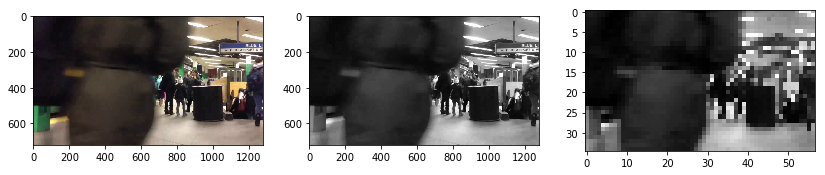

In [12]:
idx = 13
plt.figure(figsize=(14, 8))
plt.subplot(131)
plt.imshow(video[idx, ...], cmap='gray')
plt.subplot(132)
plt.imshow(newvideo[idx, ...], cmap='gray')
plt.subplot(133)
plt.imshow(newsmall[idx, ...], cmap='gray')

In [13]:
axes = np.arange(newsmall.ndim)
data = np.transpose(newsmall, axes=np.roll(axes, -1))
data.shape

(35, 57, 91)

In [14]:
pt = []
for rf in e_rf:
    rflum = p2p.stimuli.retinalmovie2electrodtimeseries(rf, data)
    ptrain = p2p.stimuli.Movie2Pulsetrain(rflum, tsample=0.005/1000)
    pt.append(ptrain)

In [15]:
for file in videofiles:
    stimfile = 'stim-%s-amplitude-old.dat' % file[:-4]
    try:
        if overwrite:
            raise FileNotFoundError('force overwrite')
        pickle.load(open(stimfile, 'rb'))
        print('File %s already exists, skip' % stimfile)
    except:
        print('Processing file %s' % stimfile)
        video = p2p.files.load_video(videopath + file)
        newvideo = np.zeros_like(video).astype(np.float32)
        newvideo = newvideo[..., 0]
        for i, frame in enumerate(video):
            newframe = sic.rgb2gray(frame)
            newvideo[i, ...] = newframe.astype(np.float32) / 255.0
            
        newsmall = np.zeros((newvideo.shape[0], sim.ofl.gridx.shape[0], sim.ofl.gridx.shape[1])).astype(np.float32)
        for i, frame in enumerate(newvideo):
            newsmall[i] = sit.resize(frame, sim.ofl.gridx.shape)
            
        axes = np.arange(newsmall.ndim)
        data = np.transpose(newsmall, axes=np.roll(axes, -1))

        stim = []
        for rf in e_rf:
            rflum = p2p.stimuli.retinalmovie2electrodtimeseries(rf, data)
            ptrain = p2p.stimuli.Movie2Pulsetrain(rflum, tsample=0.005/1000)
            pptrain = p2p.utils.TimeSeries(ptrain.tsample, ptrain.data)
            stim.append(pptrain)
            
        pickle.dump(stim, open(stimfile, "wb"))
        print('Created file %s' % stimfile)

Processing file stim-boston-train-amplitude-old.dat


2017-03-22 12:38:30,487 [pulse2percept.files] [INFO] Loaded video from file '../../data/boston-train.mp4'.


Created file stim-boston-train-amplitude-old.dat
Processing file stim-kid-pool-amplitude-old.dat


2017-03-22 12:38:36,302 [pulse2percept.files] [INFO] Loaded video from file '../../data/kid-pool.avi'.


Created file stim-kid-pool-amplitude-old.dat
Processing file stim-olly-soccer-amplitude-old.dat


2017-03-22 12:38:44,321 [pulse2percept.files] [INFO] Loaded video from file '../../data/olly-soccer.avi'.


Created file stim-olly-soccer-amplitude-old.dat
Processing file stim-zach-scoot-amplitude-old.dat


2017-03-22 12:39:32,674 [pulse2percept.files] [INFO] Loaded video from file '../../data/zach-scoot.avi'.


Created file stim-zach-scoot-amplitude-old.dat
